# Assignment 4: Customer Segmentation with Clustering

**Student Name:** [Jack Boike]

**Date:** [02/22/26]

---

## Assignment Overview

You've been hired as a data science consultant by a UK-based online gift retailer. They're spending the same amount on marketing to all customers regardless of value. Your task: segment their customer base using transaction data from 2009-2011, identify distinct customer groups, and provide actionable recommendations for each segment.

---

## Step 1: Import Libraries and Load Data

In [1]:
pip install pandas matplotlib seaborn scikit-learn

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [3]:
# Load CSV directly
df = pd.read_csv("online_retail_II.csv")

# Quick preview
print(f"Total rows: {len(df)}")
df.head()


print("\n" + "="*80)
print("CHECKPOINT: Verify dataset loaded correctly")
print(f"Dataset shape: {df.shape if df is not None else 'Not loaded'}")
print(f"Date range: [Check InvoiceDate column]")
print("="*80)

Total rows: 1067371

CHECKPOINT: Verify dataset loaded correctly
Dataset shape: (1067371, 8)
Date range: [Check InvoiceDate column]


---
## Step 2: Aggregate Transaction Data to Customer-Level RFM Features

### Clean Transaction Data

Before aggregating to customer-level, clean the transaction data:
- Remove rows with missing Customer ID
- Remove returns (negative Quantity)
- Create TotalSpend column (Quantity × Price)
- Convert InvoiceDate to datetime

In [6]:
# Remove missing Customer IDs
df = df[df['Customer ID'].notnull()]

# Remove negative quantities (returns)
df = df[df['Quantity'] > 0]

# Create TotalSpend column
df['TotalSpend'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("\n" + "="*80)
print("CHECKPOINT: After data cleaning")
print(f"Remaining transactions: {len(df)}")
print(f"Unique customers: {df['Customer ID'].nunique()}")
print("="*80)


CHECKPOINT: After data cleaning
Remaining transactions: 805620
Unique customers: 5881


### Calculate RFM Features for Each Customer

Create three features for each customer:
- **Recency**: Days since last purchase (use December 10, 2011 as reference date)
- **Frequency**: Total number of unique invoices
- **Monetary**: Total amount spent

In [7]:
# Reference date for recency
reference_date = pd.to_datetime('2011-12-10')

# Aggregate RFM features
rfm_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                      # Frequency
    'TotalSpend': 'sum'                                        # Monetary
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\n" + "="*80)
print("CHECKPOINT: RFM Features Created")
print(f"Number of customers: {len(rfm_df)}")
print(f"\nRFM Summary Statistics:")
print(rfm_df.describe())
print("="*80)


CHECKPOINT: RFM Features Created
Number of customers: 5881

RFM Summary Statistics:
         CustomerID      Recency    Frequency       Monetary
count   5881.000000  5881.000000  5881.000000    5881.000000
mean   15314.674205   200.992858     6.287196    3017.076888
std     1715.429759   209.489651    13.012879   14734.128619
min    12346.000000     0.000000     1.000000       0.000000
25%    13833.000000    25.000000     1.000000     347.800000
50%    15313.000000    95.000000     3.000000     897.620000
75%    16797.000000   379.000000     7.000000    2304.180000
max    18287.000000   738.000000   398.000000  608821.650000


---
## Step 3: Standardize Features and Determine Optimal k

### Standardize RFM Features

K-means is sensitive to feature scale, so standardize features to mean=0, std=1

In [8]:
# Standardize RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency','Frequency','Monetary']])

print("\n" + "="*80)
print("CHECKPOINT: Features Standardized")
print(f"Scaled features shape: {rfm_scaled.shape}")
print(f"Mean of scaled features: {rfm_scaled.mean(axis=0)}")
print(f"Std of scaled features: {rfm_scaled.std(axis=0)}")
print("="*80)


CHECKPOINT: Features Standardized
Scaled features shape: (5881, 3)
Mean of scaled features: [ 9.18232408e-17 -2.77886123e-17  2.41640107e-18]
Std of scaled features: [1. 1. 1.]


### Elbow Method: Test k from 2 to 10

Calculate inertia (within-cluster sum of squares) for different values of k

In [13]:
# Test k from 2 to 10
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

print("\n" + "="*80)
print("CHECKPOINT: Elbow Method & Silhouette Calculated")
print(f"Tested k values: {list(k_range)}")
print("="*80)






CHECKPOINT: Elbow Method & Silhouette Calculated
Tested k values: [2, 3, 4, 5, 6, 7, 8, 9, 10]


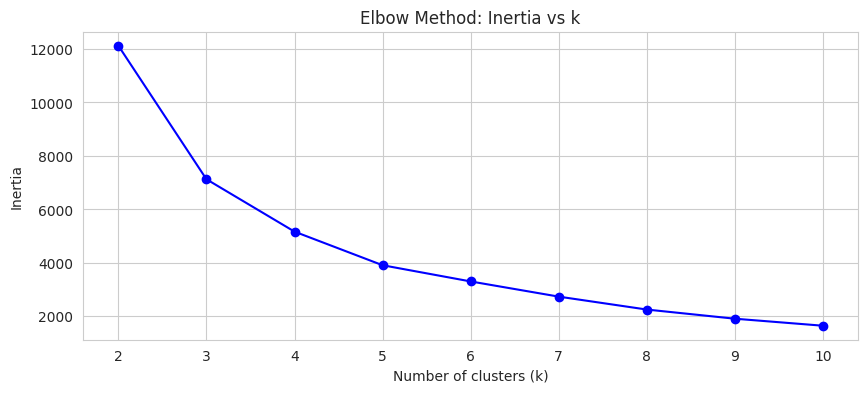

In [12]:
# TODO: Plot the elbow curve
# x-axis: k values
# y-axis: inertia
# Plot Elbow
plt.figure(figsize=(10,4))
plt.plot(k_range, inertias, marker='o', color='blue')
plt.title('Elbow Method: Inertia vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


### Silhouette Score Analysis

Calculate silhouette scores to validate cluster quality

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)  # assign clusters
    score = silhouette_score(rfm_scaled, labels)  # calculate silhouette score
    silhouette_scores.append(score)


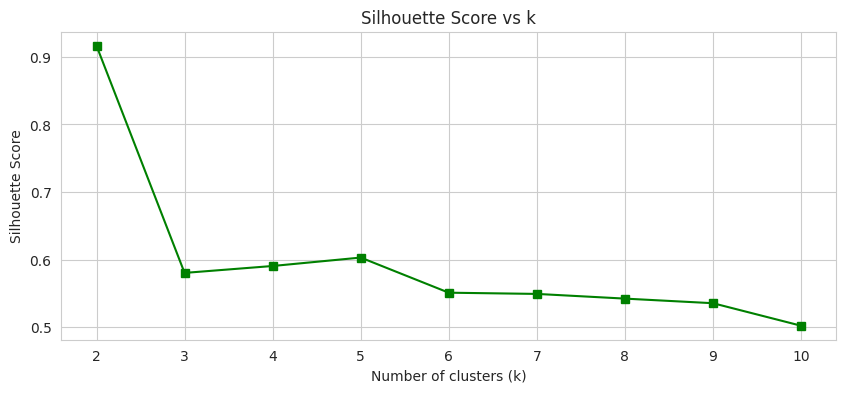


CHECKPOINT: Silhouette Scores Calculated
Silhouette Scores: [np.float64(0.916381407089036), np.float64(0.5803392830229628), np.float64(0.5905519032604194), np.float64(0.6030151758528873), np.float64(0.5510572510415608), np.float64(0.549253628077651), np.float64(0.5423113756102342), np.float64(0.5355018206708511), np.float64(0.5022035081915487)]


In [16]:
# TODO: Plot silhouette scores
# x-axis: k values
# y-axis: silhouette score

# Plot Silhouette Scores
plt.figure(figsize=(10,4))
plt.plot(k_range, silhouette_scores, marker='s', color='green')
plt.title('Silhouette Score vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

print("\n" + "="*80)
print("CHECKPOINT: Silhouette Scores Calculated")
print(f"Silhouette Scores: {silhouette_scores}")
print("="*80)


### Select Optimal k

**Your k selection justification (write 2-3 sentences):**

[I chose k = 5 because the elbow plot bends there, showing that more clusters don’t add much value. The silhouette score is also good, meaning the clusters are clear and well-separated.]

In [17]:
# TODO: Set your chosen k value
optimal_k = 5  # Replace with your chosen k (e.g., 4, 5, or 6)

print(f"Chosen k value: {optimal_k}")

Chosen k value: 5


---
## Step 4: Train K-Means Model and Visualize Segments

### Train Final K-Means Model

In [18]:
# Step 4: Train Final K-Means Model
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(rfm_scaled)

# Add cluster labels to rfm_df
rfm_df['Cluster'] = kmeans.labels_

print("\n" + "="*80)
print("CHECKPOINT: K-Means Model Trained")
print(f"Number of clusters: {optimal_k}")
if 'Cluster' in rfm_df.columns:
    print(f"\nCluster sizes:")
    print(rfm_df['Cluster'].value_counts().sort_index())
print("="*80)


CHECKPOINT: K-Means Model Trained
Number of clusters: 5

Cluster sizes:
Cluster
0    3619
1    1929
2      17
3       2
4     314
Name: count, dtype: int64


### Visualize Customer Segments

Create a 2D scatter plot showing Frequency vs Monetary, colored by cluster

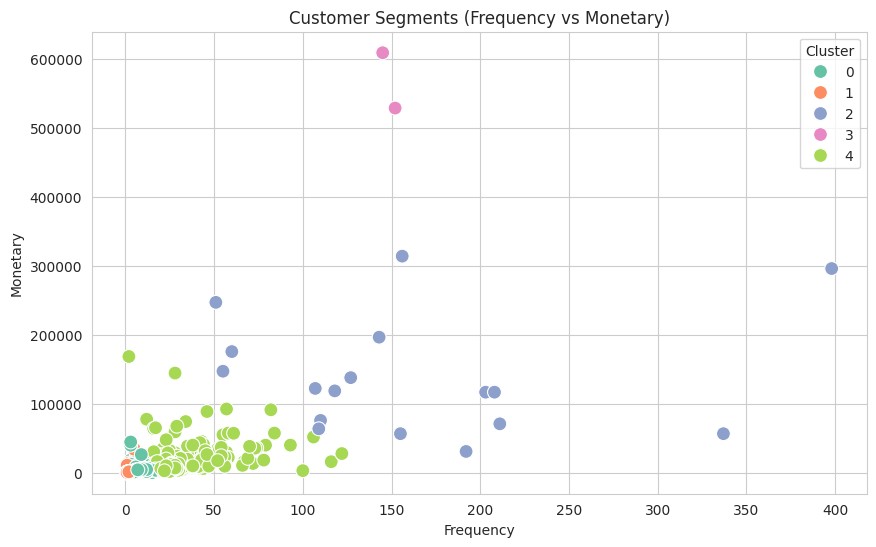

In [19]:
# Visualize Customer Segments
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=rfm_df['Frequency'],
    y=rfm_df['Monetary'],
    hue=rfm_df['Cluster'],
    palette='Set2',
    s=100
)
plt.title('Customer Segments (Frequency vs Monetary)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()



### Calculate Cluster Centers

Show the mean RFM values for each cluster

In [20]:
# Calculate Cluster Centers (mean RFM values)
cluster_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)

print("\n" + "="*80)
print("CLUSTER CENTERS (Mean RFM Values)")
print(cluster_summary)
print("="*80)


CLUSTER CENTERS (Mean RFM Values)
         Recency  Frequency   Monetary
Cluster                               
0          73.80       5.41    2036.54
1         469.93       2.16     752.40
2          27.24     161.18  137807.00
3           0.50     148.50  568712.08
4          25.55      32.51   17330.19


---
## Step 5: Interpret Segments and Provide Business Recommendations

### Segment 0: Low-Value Customers

**Customer Profile (3-5 sentences):**

These customers have not shopped recently and show very low spending and purchase frequency. They are the least engaged segment, representing limited immediate revenue potential. Marketing to them should focus on reactivation campaigns or low-cost incentives to bring them back. Their main characteristic is inactivity, so they require careful targeting to avoid wasting marketing budget.

1.   List item
2.   List item



In [21]:
segment0 = rfm_df[rfm_df['Cluster'] == 0]

# Detailed statistics for Segment 0
segment0_stats = segment0[['Recency','Frequency','Monetary']].agg(['mean','median','min','max'])
print("Segment 0 Statistics:")
print(segment0_stats)

Segment 0 Statistics:
         Recency  Frequency      Monetary
mean     73.7958    5.40619   2036.538555
median   46.0000    4.00000   1180.230000
min       0.0000    1.00000      0.000000
max     283.0000   21.00000  44534.300000


### Segment 1: Recent but Low-Spending Customers

**Customer Profile (3-5 sentences):**

These customers have made purchases recently but spend very little and buy infrequently. They may be new or occasional buyers with potential to grow into more valuable customers. They are responsive to engagement but need incentives to increase spending or purchase frequency. Personalized offers and introductory promotions could help convert them into higher-value buyers.

In [22]:
segment1 = rfm_df[rfm_df['Cluster'] == 1]

# Detailed statistics for Segment 1
segment1_stats = segment1[['Recency','Frequency','Monetary']].agg(['mean','median','min','max'])
print("Segment 1 Statistics:")
print(segment1_stats)


Segment 1 Statistics:
          Recency  Frequency      Monetary
mean    469.92535    2.15915    752.396388
median  434.00000    1.00000    376.920000
min     266.00000    1.00000      0.000000
max     738.00000   29.00000  34095.260000


### Segment 2: High-Value Loyal Customers

**Customer Profile (3-5 sentences):**

These customers purchase frequently, spend the most, and are highly engaged, with very low recency. They represent the company’s most valuable segment, driving consistent revenue. They respond well to loyalty programs, personalized communications, and exclusive offers. Retaining this segment is critical for sustaining revenue and overall business stability.

In [23]:
segment2 = rfm_df[rfm_df['Cluster'] == 2]

# Detailed statistics for Segment 2
segment2_stats = segment2[['Recency','Frequency','Monetary']].agg(['mean','median','min','max'])
print("Segment 2 Statistics:")
print(segment2_stats)

Segment 2 Statistics:
           Recency   Frequency       Monetary
mean     27.235294  161.176471  137806.995294
median    2.000000  143.000000  118628.080000
min       0.000000   51.000000   30861.060000
max     372.000000  398.000000  313946.370000


Segment 3: Infrequent Big Spenders

These customers spend a lot per purchase but buy infrequently, so their recency is higher than loyal customers. They offer significant revenue potential if they can be encouraged to shop more regularly. Seasonal promotions, product bundles, or special incentives can increase their purchase frequency. They are high-value but irregular buyers.

Segment 4: Moderate Spenders

These customers have medium spending and purchase frequency with moderate recency. They provide steady revenue but are not top contributors. They may respond well to general promotions or engagement campaigns to increase spending and loyalty. They represent a middle ground segment—reliable but with room for growth.

---
## Business Recommendations

### Recommendation 1: Loyalty Program for High-Value Customers

**Which segment(s) does this target?** Segment 2 – High-Value Loyal Customers

**Recommendation (3-5 sentences):**

Implement an exclusive loyalty program to reward your most valuable customers. Offer personalized discounts, early access to new products, or VIP-only perks. This will strengthen their engagement, encourage repeat purchases, and increase lifetime value. Retaining these customers is more cost-effective than acquiring new ones, and they can become brand advocates.

### Recommendation 2: Reactivation Campaign for Low-Value Customers

**Which segment(s) does this target?** Segment 0 – Low-Value Customers

**Recommendation (3-5 sentences):**

Use targeted email campaigns or limited-time discounts to re-engage inactive customers. Highlight popular or seasonal products to spark interest. The goal is to bring them back to make their first or second purchase without overspending on marketing. Tracking responses will help identify which offers work best for reactivation.

### Recommendation 3: Upsell and Engagement Offers for Recent Low-Spenders

**Which segment(s) does this target?** Segment 1 – Recent but Low-Spending Customers

**Recommendation (3-5 sentences):**

Encourage higher spending and more frequent purchases by sending personalized product recommendations or bundle offers. Limited-time promotions or introductory incentives can motivate them to explore more products. Over time, some may convert into moderate or high-value customers, increasing their contribution to overall revenue.

---
## Step 6: Submit Your Work

Before submitting:
1. Make sure all code cells run without errors
2. Verify you have:
   - RFM features properly calculated
   - Elbow method and silhouette score visualizations
   - Written justification for your k selection
   - Customer segment scatter plot
   - Descriptive names and profiles for each segment
   - Three specific business recommendations
3. Check that all visualizations display correctly

Then push to GitHub:
```bash
git add .
git commit -m 'completed customer segmentation assignment'
git push
```

Submit your GitHub repository link on the course platform.